In [1]:
import nfl_data_py as nfl
plt.style.use('bmh')

### Preprocess players data

In [2]:
df1 = nfl.import_players()
print(df1.shape)

# get year of birth 
def get_year(x):
    if x == '':
        return 0
    sep = '-' if x.find('-') > 0 else '/'
    x = [x1 for x1 in x.split(sep) if len(x1) == 4]
    return int(x[0])
df1['birth_year2'] = df1['birth_date'].fillna('').map(get_year)

# weight conversion
c1 = 0.45359237
df1['weight_kg'] = df1['weight'] * c1
# df1['weight_kg'] = df1['weight'].fillna('').replace('',0).astype(float) * c1
df1.loc[df1.weight_kg < 60, 'weight_kg'] = np.nan

# height conversion
c2 = 2.54
# old format
# def convert(x):
#     x = x.split('-')
#     if len(x) == 1:
#         return 0
#     out = int(x[0])*12 + int(x[1])
#     return out*c2
# df1['height_cm'] = df1['height'].fillna('').replace('','0-0').map(convert)
df1['height_cm'] = df1['height']*c2
df1.loc[df1.height_cm < 160, 'height_cm'] = np.nan

df1['bmi_calc'] = df1['weight_kg'] / (df1['height_cm']/100)**2

# add positions categories
df_pos = pd.read_html('https://www.rookieroad.com/football/positions/position-abbreviations/')[0]
df_pos.rename(columns = {'Abbreviation': 'position'}, inplace = True)

# merge
feats_used = ['gsis_id','display_name','birth_year2','height_cm','weight_kg','bmi_calc',
              'team_abbr','position_group','position','Position','Category']
df1 = df1.merge(df_pos, how = 'left')[feats_used].rename(columns = {'gsis_id':'player_id'})
print(df1.shape)
df1[:3]

(20035, 33)
(20035, 11)


,player_id,display_name,birth_year2,height_cm,weight_kg,bmi_calc,team_abbr,position_group,position,Position,Category
0,00-0004866,'Omar Ellison,0,185.42,90.72,26.39,LAC,WR,WR,Wide Receiver,Offense
1,00-0032889,A'Shawn Robinson,1995,193.04,149.69,40.17,NYG,DL,DT,Defensive Tackle,Defense
2,00-0037845,A.J. Arcuri,0,200.66,145.15,36.05,LA,OL,T,Tackle,Offense


In [3]:
# static player features from main dataset
df = pd.read_csv('data/nflpy.csv')
del df['Unnamed: 0']

# get dates
df['birth_year'] = df.season - df.age
df['start_year'] = df.season - df.years_exp

df2 = df.groupby('player_id')['season'].agg([max,len])
df2.columns = ['season_max','season_len']

df3 = df.groupby('player_id')[['birth_year','start_year','draft_number']].agg(max)
df2 = pd.concat([df2,df3], axis = 1).reset_index()
print(df2.shape)
df2[:3]

(1614, 6)


,player_id,season_max,season_len,birth_year,start_year,draft_number
0,00-0007091,2016,1,nan,nan,nan
1,00-0010346,2016,1,nan,nan,nan
2,00-0019596,2023,8,"1,977.00","2,000.00",199.00


In [4]:
# merge and add some feats
df2 = df2.merge(df1)
df2['birth_year'] = df2['birth_year'].fillna(df2['birth_year2'])
df2.loc[df2.birth_year < 1900, 'birth_year'] = np.nan
del df2['birth_year2']

np.random.seed(2017)
df2['fold'] = np.random.randint(0,5,len(df2))

# some nulls replacing
df2['draft_number'] = (df2['draft_number'].fillna(0) > 0).astype(int)
repl_birth = {
    '00-0036669': 1998
}
repl_start = {
    '00-0036669': 2017
}
df2['birth_year'] = df2.birth_year.fillna(df2.player_id.map(repl_birth))
df2['start_year'] = df2.start_year.fillna(df2.player_id.map(repl_start))

df2.to_pickle('data/df_players.pkl')
print(df2.shape)
df2[:5]

(1614, 16)


,player_id,season_max,season_len,birth_year,start_year,draft_number,display_name,height_cm,weight_kg,bmi_calc,team_abbr,position_group,position,Position,Category,fold
0,00-0007091,2016,1,"1,975.00",nan,0,Matt Hasselbeck,193.04,106.59,28.60,IND,QB,QB,Quarterback,Offense,3
1,00-0010346,2016,1,"1,976.00",nan,0,Peyton Manning,195.58,104.33,27.27,DEN,QB,QB,Quarterback,Offense,1
2,00-0019596,2023,8,"1,977.00","2,000.00",1,Tom Brady,193.04,102.06,27.39,TB,QB,QB,Quarterback,Offense,2
3,00-0020245,2016,1,"1,980.00",nan,0,Mike Vick,182.88,95.25,28.48,PIT,QB,QB,Quarterback,Offense,0
4,00-0020337,2017,2,"1,979.00","2,001.00",0,Steve Smith,175.26,88.45,28.80,BAL,WR,WR,Wide Receiver,Offense,2


In [5]:
df2.isnull().sum()

player_id           0
season_max          0
season_len          0
birth_year        143
start_year        344
draft_number        0
display_name        0
height_cm           0
weight_kg           0
bmi_calc            0
team_abbr           0
position_group      0
position            0
Position            2
Category            2
fold                0
dtype: int64

In [6]:
df2.groupby('fold').size()

fold
0    300
1    329
2    343
3    316
4    326
dtype: int64

In [7]:
# some duplicated names
ind = df2.display_name.value_counts().index[:4]
df2[df2.display_name.isin(ind)].sort_values('display_name')

,player_id,season_max,season_len,birth_year,start_year,draft_number,display_name,height_cm,weight_kg,bmi_calc,team_abbr,position_group,position,Position,Category,fold
415,00-0030404,2021,6,"1,990.00","2,013.00",1,Chris Thompson,172.72,88.45,29.65,CHI,RB,RB,Running Back,Offense,3
952,00-0033855,2018,1,"1,994.00",nan,0,Chris Thompson,182.88,79.38,23.73,SF,WR,WR,Wide Receiver,Offense,4
122,00-0026957,2017,1,"1,987.00",nan,0,David Johnson,187.96,117.93,33.38,PIT,TE,TE,Tight End,Offense,3
691,00-0032187,2023,8,"1,991.00","2,015.00",1,David Johnson,185.42,101.60,29.55,NO,RB,RB,Running Back,Offense,1
375,00-0030073,2016,1,"1,990.00","2,013.00",1,Duke Williams,180.34,91.17,28.03,IND,DB,SS,Strong Safety,Defense,4
810,00-0032945,2020,1,"1,993.00","2,016.00",0,Duke Williams,190.50,102.06,28.12,BUF,WR,WR,Wide Receiver,Offense,3
363,00-0029857,2020,1,"1,989.00","2,013.00",0,Ryan Griffin,195.58,95.25,24.90,TB,QB,QB,Quarterback,Offense,2
383,00-0030108,2023,8,"1,990.00","2,013.00",1,Ryan Griffin,198.12,115.67,29.47,CHI,TE,TE,Tight End,Offense,1


In [8]:
df_players = df2

### Preprocess season data

In [9]:
# read dataset
df = pd.read_csv('data/nflpy.csv')

# unused feats (we have them in players data)
feats_del = ['Unnamed: 0','name','years_exp','age','draft_number']
for f in feats_del:
    del df[f]
    
print(df.shape)
df[:3]

(4655, 59)


,player_id,season,team,bmi,fantasy_points_per_game,fantasy_points_ppr,games,receptions,targets,passing_tds,interceptions,passing_epa,receiving_epa,carries,rushing_epa,rushing_tds,receiving_tds,target_share,passing_yards,passing_air_yards,passing_yards_after_catch,rushing_yards,receiving_yards,receiving_air_yards,receiving_yards_after_catch,air_yards_share,attempts,completions,pacr,dakota,sack_fumbles,rushing_fumbles,receiving_fumbles,racr,wopr_x,yac_sh,ry_sh,rtd_sh,rfd_sh,dom,w8dom,yptmpa,ppr_sh,completions_per_game,attempts_per_game,passing_yards_per_game,passing_tds_per_game,interceptions_per_game,passing_air_yards_per_game,passing_yards_after_catch_per_game,rushing_attempts_per_game,rushing_yards_per_game,rushing_tds_per_game,receptions_per_game,targets_per_game,receiving_yards_per_game,receiving_tds_per_game,receiving_air_yards_per_game,receiving_yards_after_catch_per_game
0,00-0007091,2016,NaN,nan,11.39,91.10,8,0,0,9,5.00,-0.11,0.00,16,-5.87,0,0,0.00,"1,690.00","1,900.00",779.00,15.00,0.00,0.00,0.00,0.00,256,156,7.42,0.53,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,19.50,32.00,211.25,1.12,0.62,237.50,97.38,2.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,00-0010346,2016,NaN,nan,9.14,91.36,10,0,0,9,17.00,-31.96,0.00,6,-3.62,0,0,0.00,"2,249.00","3,112.00",967.00,-6.00,0.00,0.00,0.00,0.00,331,198,7.33,0.52,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,19.80,33.10,224.90,0.90,1.70,311.20,96.70,0.60,-0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,00-0019596,2016,NE,0.04,21.51,344.70,16,1,1,36,7.00,127.25,3.13,34,6.85,3,0,0.02,"4,770.00","4,915.00","2,414.00",53.00,36.00,7.00,29.00,0.01,624,402,17.19,1.99,5,1.00,0.00,5.14,0.04,0.01,0.01,0.00,0.00,0.00,0.01,0.06,0.21,25.12,39.00,298.12,2.25,0.44,307.19,150.88,2.12,3.31,0.19,0.06,0.06,2.25,0.00,0.44,1.81


In [10]:
df.isnull().sum()

player_id                                  0
season                                     0
team                                    1057
bmi                                     1175
fantasy_points_per_game                    0
fantasy_points_ppr                         0
games                                      0
receptions                                 0
targets                                    0
passing_tds                                0
interceptions                              0
passing_epa                                0
receiving_epa                              0
carries                                    0
rushing_epa                                0
rushing_tds                                0
receiving_tds                              0
target_share                               0
passing_yards                              0
passing_air_yards                          0
passing_yards_after_catch                  0
rushing_yards                              0
receiving_

In [11]:
eps = 1e-3

In [12]:
# passing features structuring
dict_repl = {
    'attempts': 'passing_attempts',
    'completions': 'passing_completions',
    'completions_per_game': 'passing_completions_per_game',
    'attempts_per_game': 'passing_attempts_per_game',
    'air_yards_share': 'passing_air_yards_share',
    'pacr': 'passing_pacr',
    'sack_fumbles': 'passing_fumbles',
    'interceptions': 'passing_interceptions',
    'interceptions_per_game': 'passing_interceptions_per_game',
}
df.rename(columns = dict_repl, inplace = True)

# absolute features
feats_passing_abs = [
 'passing_attempts',
 'passing_completions',
 'passing_yards',
 'passing_air_yards',
 'passing_yards_after_catch',
 'passing_tds',
 'passing_interceptions',
 'passing_fumbles',
 'passing_points',
]
df['passing_points'] = df.passing_tds*4 + df.passing_yards*0.04 - df.passing_interceptions*2  #- df.passing_fumbles*2

# per game features
for f in feats_passing_abs:
    df[f + '_per_game'] = df[f] / df.games

feats_passing_game = [
 'passing_attempts_per_game',
 'passing_completions_per_game',
 'passing_yards_per_game',
 'passing_air_yards_per_game',
 'passing_yards_after_catch_per_game',
 'passing_tds_per_game',
 'passing_interceptions_per_game',
 'passing_fumbles_per_game',
 'passing_points_per_game',
]

# different shares and coefs
df['passing_complete_share'] = df['passing_completions'] / (eps + df['passing_attempts'])
df['passing_interceptions_share'] = df['passing_interceptions'] / (eps + df['passing_attempts'])
df['passing_fumbles_share'] = df['passing_fumbles'] / (eps + df['passing_attempts'])
df['passing_points_share'] = df['passing_points'] / (eps + df['fantasy_points_ppr'])

df['passing_air_yards_share'] = df['passing_air_yards'] / (eps + df['passing_yards'])
df['passing_yards_after_catch_share'] = df['passing_yards_after_catch'] / (eps + df['passing_yards'])

feats_passing_share = [
 'passing_complete_share',
 'passing_interceptions_share',
 'passing_fumbles_share',
 'passing_points_share',
 'passing_air_yards_share',
 'passing_yards_after_catch_share',
 'passing_epa',
 'passing_pacr',
]

In [13]:
# receiving features structuring
dict_repl = {
    'receptions': 'receiving_receptions',
    'receptions_per_game': 'receiving_receptions_per_game',
    'racr': 'receiving_racr',
    'wopr_x': 'receiving_wopr_x',
    'targets': 'receiving_targets',
    'targets_per_game': 'receiving_targets_per_game',
    'target_share': 'receiving_target_team_share',

}
df.rename(columns = dict_repl, inplace = True)

# absolute features
feats_receiving_abs = [
 'receiving_targets',
 'receiving_receptions',
 'receiving_yards',
 'receiving_air_yards',
 'receiving_yards_after_catch',
 'receiving_tds',
 'receiving_fumbles',
 'receiving_points'
]
df['receiving_points'] = df.receiving_tds*6 + df.receiving_yards*0.1 - df.receiving_fumbles*2 + df.receiving_receptions*1

# per game features
for f in feats_receiving_abs:
    df[f + '_per_game'] = df[f] / df.games

feats_receiving_game = [
 'receiving_targets_per_game',
 'receiving_receptions_per_game',
 'receiving_yards_per_game',
 'receiving_air_yards_per_game',
 'receiving_yards_after_catch_per_game',
 'receiving_tds_per_game',
 'receiving_fumbles_per_game',
 'receiving_points_per_game'
]

# different shares and coefs
df['receiving_receptions_share'] = df['receiving_receptions'] / (eps + df['receiving_targets'])
df['receiving_fumbles_share'] = df['receiving_fumbles'] / (eps + df['receiving_targets'])
df['receiving_points_share'] = df['receiving_points'] / (eps + df['fantasy_points_ppr'])

df['receiving_air_yards_share'] = df['receiving_air_yards'] / (eps + df['receiving_yards'])
df['receiving_yards_after_catch_share'] = df['receiving_yards_after_catch'] / (eps + df['receiving_yards'])

feats_receiving_share = [
 'receiving_receptions_share',
 'receiving_fumbles_share',
 'receiving_points_share',
 'receiving_air_yards_share',
 'receiving_yards_after_catch_share',
 'receiving_epa',
 'receiving_racr',
 'receiving_wopr_x',
 'receiving_target_team_share',
]

In [14]:
# rushing features structuring
dict_repl = {
    'carries': 'rushing_carries',
}
df.rename(columns = dict_repl, inplace = True)

# absolute features
feats_rushing_abs = [
 'rushing_carries',
 'rushing_yards',
 'rushing_tds',
 'rushing_fumbles',
 'rushing_points',
]
df['rushing_points'] = df.rushing_tds*6 + df.rushing_yards*0.1  - df.rushing_fumbles*2

# per game features
for f in feats_rushing_abs:
    df[f + '_per_game'] = df[f] / df.games

feats_rushing_game = [
 'rushing_carries_per_game',
 'rushing_yards_per_game',
 'rushing_tds_per_game',
 'rushing_fumbles_per_game',
 'rushing_points_per_game',
]

# different shares and coefs
df['rushing_fumbles_share'] = df['rushing_fumbles'] / (eps + df['rushing_carries'])
df['rushing_points_share'] = df['rushing_points'] / (eps + df['fantasy_points_ppr'])

feats_rushing_share = [
 'rushing_fumbles_share',
 'rushing_points_share',
 'rushing_epa',
]

calc_points          359,095.36
fantasy_points_ppr   362,817.36
dtype: float64


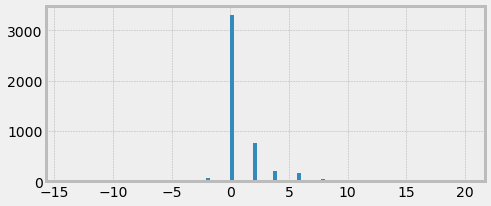

In [15]:
# calculate total points and compare
df['calc_points'] = df.passing_points + df.rushing_points + df.receiving_points
feats1 = ['calc_points','fantasy_points_ppr']
print(df[feats1].sum())

_ = df[feats1].diff(axis = 1).iloc[:,1].hist(figsize = (7,3), bins = 100)

In [16]:
# merge with players data
print(df.shape)
df = df.merge(df_players)
print(df.shape)
df[:3]

(4655, 82)
(4655, 97)


,player_id,season,team,bmi,fantasy_points_per_game,fantasy_points_ppr,games,receiving_receptions,receiving_targets,passing_tds,passing_interceptions,passing_epa,receiving_epa,rushing_carries,rushing_epa,rushing_tds,receiving_tds,receiving_target_team_share,passing_yards,passing_air_yards,passing_yards_after_catch,rushing_yards,receiving_yards,receiving_air_yards,receiving_yards_after_catch,passing_air_yards_share,passing_attempts,passing_completions,passing_pacr,dakota,passing_fumbles,rushing_fumbles,receiving_fumbles,receiving_racr,receiving_wopr_x,yac_sh,ry_sh,rtd_sh,rfd_sh,dom,w8dom,yptmpa,ppr_sh,passing_completions_per_game,passing_attempts_per_game,passing_yards_per_game,passing_tds_per_game,passing_interceptions_per_game,passing_air_yards_per_game,passing_yards_after_catch_per_game,rushing_attempts_per_game,rushing_yards_per_game,rushing_tds_per_game,receiving_receptions_per_game,receiving_targets_per_game,receiving_yards_per_game,receiving_tds_per_game,receiving_air_yards_per_game,receiving_yards_after_catch_per_game,passing_points,passing_fumbles_per_game,passing_points_per_game,passing_complete_share,passing_interceptions_share,passing_fumbles_share,passing_points_share,passing_yards_after_catch_share,receiving_points,receiving_fumbles_per_game,receiving_points_per_game,receiving_receptions_share,receiving_fumbles_share,receiving_points_share,receiving_air_yards_share,receiving_yards_after_catch_share,rushing_points,rushing_carries_per_game,rushing_fumbles_per_game,rushing_points_per_game,rushing_fumbles_share,rushing_points_share,calc_points,season_max,season_len,birth_year,start_year,draft_number,display_name,height_cm,weight_kg,bmi_calc,team_abbr,position_group,position,Position,Category,fold
0,00-0007091,2016,NaN,nan,11.39,91.10,8,0,0,9,5.00,-0.11,0.00,16,-5.87,0,0,0.00,"1,690.00","1,900.00",779.00,15.00,0.00,0.00,0.00,1.12,256,156,7.42,0.53,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,19.50,32.00,211.25,1.12,0.62,237.50,97.38,2.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,93.60,0.38,11.70,0.61,0.02,0.01,1.03,0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.50,2.00,0.00,0.19,0.00,0.02,95.10,2016,1,"1,975.00",nan,0,Matt Hasselbeck,193.04,106.59,28.60,IND,QB,QB,Quarterback,Offense,3
1,00-0010346,2016,NaN,nan,9.14,91.36,10,0,0,9,17.00,-31.96,0.00,6,-3.62,0,0,0.00,"2,249.00","3,112.00",967.00,-6.00,0.00,0.00,0.00,1.38,331,198,7.33,0.52,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,19.80,33.10,224.90,0.90,1.70,311.20,96.70,0.60,-0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,91.96,0.10,9.20,0.60,0.05,0.00,1.01,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.60,0.60,0.00,-0.06,0.00,-0.01,91.36,2016,1,"1,976.00",nan,0,Peyton Manning,195.58,104.33,27.27,DEN,QB,QB,Quarterback,Offense,1
2,00-0019596,2016,NE,0.04,21.51,344.70,16,1,1,36,7.00,127.25,3.13,34,6.85,3,0,0.02,"4,770.00","4,915.00","2,414.00",53.00,36.00,7.00,29.00,1.03,624,402,17.19,1.99,5,1.00,0.00,5.14,0.04,0.01,0.01,0.00,0.00,0.00,0.01,0.06,0.21,25.12,39.00,298.12,2.25,0.44,307.19,150.88,2.12,3.31,0.19,0.06,0.06,2.25,0.00,0.44,1.81,320.80,0.31,20.05,0.64,0.01,0.01,0.93,0.51,4.60,0.00,0.29,1.00,0.00,0.01,0.19,0.81,21.30,2.12,0.06,1.33,0.03,0.06,346.70,2023,8,"1,977.00","2,000.00",1,Tom Brady,193.04,102.06,27.39,TB,QB,QB,Quarterback,Offense,2


In [17]:
# static features useful for training
dict_repl = {
    'height_cm': 'static_height_cm',
    'weight_kg': 'static_weight_kg',
    'bmi_calc': 'static_bmi_calc',
    'birth_year': 'static_birth_year',
    'start_year': 'static_start_year',
    'draft_number': 'static_draft_number'
}
df.rename(columns = dict_repl, inplace = True)

In [18]:
# replace other feature names
dict_repl = {
    'dakota': '_other_dakota',
    'yac_sh': '_other_yac_sh',
    'ry_sh': '_other_ry_sh',
    'rtd_sh': '_other_rtd_sh',
    'rfd_sh': '_other_rfd_sh',
    'dom': '_other_dom',
    'w8dom': '_other_w8dom',
    'yptmpa': '_other_yptmpa',
    'ppr_sh': '_other_ppr_sh',
}
df.rename(columns = dict_repl, inplace = True)

In [19]:
# replace team nulls 
feats_sort = ['player_id','season']
df = df.sort_values(feats_sort).reset_index()
del df['index']

df['team'] = df.groupby('player_id').team.ffill()
df['team'] = df.groupby('player_id').team.bfill()

display(df[['team','team_abbr']].isnull().sum())

df['team'] = df['team'].fillna(df['team_abbr'])
del df['team_abbr']

team         281
team_abbr      0
dtype: int64

In [20]:
# save to pickle
df.to_pickle('data/df_season.pkl')
df[:3]

,player_id,season,team,bmi,fantasy_points_per_game,fantasy_points_ppr,games,receiving_receptions,receiving_targets,passing_tds,passing_interceptions,passing_epa,receiving_epa,rushing_carries,rushing_epa,rushing_tds,receiving_tds,receiving_target_team_share,passing_yards,passing_air_yards,passing_yards_after_catch,rushing_yards,receiving_yards,receiving_air_yards,receiving_yards_after_catch,passing_air_yards_share,passing_attempts,passing_completions,passing_pacr,_other_dakota,passing_fumbles,rushing_fumbles,receiving_fumbles,receiving_racr,receiving_wopr_x,_other_yac_sh,_other_ry_sh,_other_rtd_sh,_other_rfd_sh,_other_dom,_other_w8dom,_other_yptmpa,_other_ppr_sh,passing_completions_per_game,passing_attempts_per_game,passing_yards_per_game,passing_tds_per_game,passing_interceptions_per_game,passing_air_yards_per_game,passing_yards_after_catch_per_game,rushing_attempts_per_game,rushing_yards_per_game,rushing_tds_per_game,receiving_receptions_per_game,receiving_targets_per_game,receiving_yards_per_game,receiving_tds_per_game,receiving_air_yards_per_game,receiving_yards_after_catch_per_game,passing_points,passing_fumbles_per_game,passing_points_per_game,passing_complete_share,passing_interceptions_share,passing_fumbles_share,passing_points_share,passing_yards_after_catch_share,receiving_points,receiving_fumbles_per_game,receiving_points_per_game,receiving_receptions_share,receiving_fumbles_share,receiving_points_share,receiving_air_yards_share,receiving_yards_after_catch_share,rushing_points,rushing_carries_per_game,rushing_fumbles_per_game,rushing_points_per_game,rushing_fumbles_share,rushing_points_share,calc_points,season_max,season_len,static_birth_year,static_start_year,static_draft_number,display_name,static_height_cm,static_weight_kg,static_bmi_calc,position_group,position,Position,Category,fold
0,00-0007091,2016,IND,nan,11.39,91.10,8,0,0,9,5.00,-0.11,0.00,16,-5.87,0,0,0.00,"1,690.00","1,900.00",779.00,15.00,0.00,0.00,0.00,1.12,256,156,7.42,0.53,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,19.50,32.00,211.25,1.12,0.62,237.50,97.38,2.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,93.60,0.38,11.70,0.61,0.02,0.01,1.03,0.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.50,2.00,0.00,0.19,0.00,0.02,95.10,2016,1,"1,975.00",nan,0,Matt Hasselbeck,193.04,106.59,28.60,QB,QB,Quarterback,Offense,3
1,00-0010346,2016,DEN,nan,9.14,91.36,10,0,0,9,17.00,-31.96,0.00,6,-3.62,0,0,0.00,"2,249.00","3,112.00",967.00,-6.00,0.00,0.00,0.00,1.38,331,198,7.33,0.52,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,19.80,33.10,224.90,0.90,1.70,311.20,96.70,0.60,-0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,91.96,0.10,9.20,0.60,0.05,0.00,1.01,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.60,0.60,0.00,-0.06,0.00,-0.01,91.36,2016,1,"1,976.00",nan,0,Peyton Manning,195.58,104.33,27.27,QB,QB,Quarterback,Offense,1
2,00-0019596,2016,NE,0.04,21.51,344.70,16,1,1,36,7.00,127.25,3.13,34,6.85,3,0,0.02,"4,770.00","4,915.00","2,414.00",53.00,36.00,7.00,29.00,1.03,624,402,17.19,1.99,5,1.00,0.00,5.14,0.04,0.01,0.01,0.00,0.00,0.00,0.01,0.06,0.21,25.12,39.00,298.12,2.25,0.44,307.19,150.88,2.12,3.31,0.19,0.06,0.06,2.25,0.00,0.44,1.81,320.80,0.31,20.05,0.64,0.01,0.01,0.93,0.51,4.60,0.00,0.29,1.00,0.00,0.01,0.19,0.81,21.30,2.12,0.06,1.33,0.03,0.06,346.70,2023,8,"1,977.00","2,000.00",1,Tom Brady,193.04,102.06,27.39,QB,QB,Quarterback,Offense,2


### checks

In [21]:
feats1 = ['passing_air_yards_share','passing_air_yards','passing_yards']
df[df.passing_air_yards_share == np.inf][feats1][:10]

,passing_air_yards_share,passing_air_yards,passing_yards


In [22]:
feats1 = ['passing_air_yards_share','passing_air_yards','passing_yards']
df[df.passing_air_yards_share == np.nan][feats1][:10]

,passing_air_yards_share,passing_air_yards,passing_yards


In [23]:
# df.isnull().sum()

In [24]:
# (df == np.inf).sum()